Code for comparions and evaluation of data

In [30]:
import os
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from matplotlib.colors import Normalize 

In [17]:
# Get the relevant blocks at the innner mierendorff Insel
# Load Block level data 
block_data = gpd.read_file(r'auxillary\00_block_shape.shp')
outer_mierendorff = ["019609", "019017", "019808", "019901", "020902", "019708"]
block_data['blknr'] = block_data["blknr"].astype(str)
block_data = block_data[~block_data["blknr"].isin(outer_mierendorff)]

In [20]:
data_dict = {
    "project": [],
    "blknr": [],
    "QH_sys_MWhyr_2020": [],
    "E_sys_MWhyr_2020": [],
    "QH_sys_MWhyr_2021": [],
    "E_sys_MWhyr_2021": [],
    "QH_sys_MWhyr_2022": [],
    "E_sys_MWhyr_2022": []
}


for project in os.listdir(r'CEA_model337'):
    for year in os.listdir(r'CEA_model337/'+project):
        if year == "2020":
            # Load Building level data and shape file
            CEA_shape_path = os.path.join('CEA_model337' , project, year, 'inputs', 'building-geometry' ,'zone.shp')
            CEA_shape = gpd.read_file(CEA_shape_path)
            CEA_shape = CEA_shape.to_crs(block_data.crs)
            # Perform spatial join to find which block each building in CEA_shape belongs to
            buildings_with_block = gpd.sjoin(CEA_shape, block_data, how="inner", predicate='intersects')
        block_numbers = list(block_data["blknr"])
        for block_number in block_numbers:
            buildings_in_block = buildings_with_block[buildings_with_block['blknr'] == block_number]
            if buildings_in_block.empty:
                    continue
            else:
                data_dict['blknr'].append(block_number)
                data_dict['project'].append(project) 
                for year in [2020, 2021, 2022]:
                    path = os.path.join('CEA_model', 'DefaultModel', f'{year}_GER_Updated', 'outputs', 'data', 'demand', 'Total_demand.csv')
                    df = pd.read_csv(path)
                    # Extract building names into a list
                    building_names = buildings_in_block['Name'].tolist()  # Assuming 'Name' is the column with building names
                    filtered_df = df[df['Name'].isin(building_names)]
                    
                    # Append the block number and aggregated values to their respective lists in data_dict
                    
                    data_dict[f"QH_sys_MWhyr_{year}"].append(filtered_df["QH_sys_MWhyr"].sum())
                    data_dict[f"E_sys_MWhyr_{year}"].append(filtered_df["E_sys_MWhyr"].sum())


# Convert the data_dict to a DataFrame
data_df = pd.DataFrame(data_dict)


In [21]:
# Load Measured Data for electricity
elec_data = pd.read_excel(r'auxillary\Elec_Berlin_2020_2022.xls')
gas_data = pd.read_excel(r'auxillary\Gas_Berlin_2020_2022.xls')
dh_data = pd.read_excel(r'auxillary\DH_Berlin_2020_2022.xls')
block_data["blknr"] = block_data["blknr"].astype(int)   

dh_data = dh_data.rename(columns={"Blocknummer": "blknr"})
dh_data_shapes = block_data.merge(dh_data, on='blknr', how='left')
elec_data = elec_data.rename(columns={"Blocknummer": "blknr"})  
elec_data_shapes = block_data.merge(elec_data, on='blknr', how='left')
gas_data = gas_data.rename(columns={"Blocknummer": "blknr"})
gas_data_shapes = block_data.merge(gas_data, on='blknr', how='left')

# Adjust types 
# Code from: https://github.com/TUB-DVG/TECDEM/blob/main/experiments/81_PlotBlock.ipynb 
elec_columns_to_check = [
        "Stromverbrauch 2022 [MWh]",
        "Stromverbrauch 2021 [MWh]",
        "Stromverbrauch 2020 [MWh]"
    ]

for column in elec_columns_to_check:
        elec_data_shapes[column] = pd.to_numeric(elec_data_shapes[column], errors='coerce')

elec_data_shapes["valid_entries"] = elec_data_shapes[elec_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

gas_columns_to_check = [
        "Gasverbrauch 2022 [MWh]",
        "Gasverbrauch 2021 [MWh]",
        "Gasverbrauch 2020 [MWh]"
    ]

for column in gas_columns_to_check:
        gas_data_shapes[column] = pd.to_numeric(gas_data_shapes[column], errors='coerce')

gas_data_shapes["valid_entries"] = gas_data_shapes[gas_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

dh_columns_to_check = [
        "Fernwärmeverbrauch 2022 [MWh]",
        "Fernwärmeverbrauch 2021 [MWh]",
        "Fernwärmeverbrauch 2020 [MWh]"
    ]

for column in dh_columns_to_check:
        dh_data_shapes[column] = pd.to_numeric(dh_data_shapes[column], errors='coerce')

dh_data_shapes["valid_entries"] = dh_data_shapes[dh_columns_to_check].apply(lambda x: (x > 0).sum(), axis=1)

In [22]:
# Calculate MAE for each project and block
mae_dict = {}

for project in data_df['project'].unique():
    project_df = data_df[data_df['project'] == project]
    for blk in project_df['blknr'].unique():
        try:
            mae = mean_absolute_error(
                project_df[["QH_sys_MWhyr_2020", "QH_sys_MWhyr_2021", "QH_sys_MWhyr_2022"]][project_df['blknr'] == blk],
                project_df[["E_sys_MWhyr_2020", "E_sys_MWhyr_2021", "E_sys_MWhyr_2022"]][project_df['blknr'] == blk]
            )
            mae_dict[(project, blk)] = mae
        except ValueError:
            print("ValueError")
            mae_dict[(project, blk)] = ""
        except TypeError:
            print("TypeError")
            mae_dict[(project, blk)] = ""

# Create a DataFrame from the MAE dictionary
mae_df = pd.DataFrame(list(mae_dict.items()), columns=['project_blknr', 'mae'])
mae_df[['project', 'blknr']] = pd.DataFrame(mae_df['project_blknr'].tolist(), index=mae_df.index)
mae_df.drop(columns='project_blknr', inplace=True)
mae_df['blknr'] = mae_df['blknr'].astype(int)

In [28]:
mae_df.sort_values(by='mae', ascending=False, inplace=True)


,mae,project,blknr
33,3183.992333,Baseline,20051
87,3183.992333,Benchmark_Advanced_Refurbishment,20051
56,3183.992333,Benchmark,20051
118,3183.992333,Benchmark_Normal_Refurbishment,20051
69,2909.264333,Benchmark_Advanced_Refurbishment,19742
...,...,...,...
23,0.000000,Baseline,19759
24,0.000000,Baseline,19760
144,0.000000,DefaultModel,20052
28,0.000000,Baseline,20028


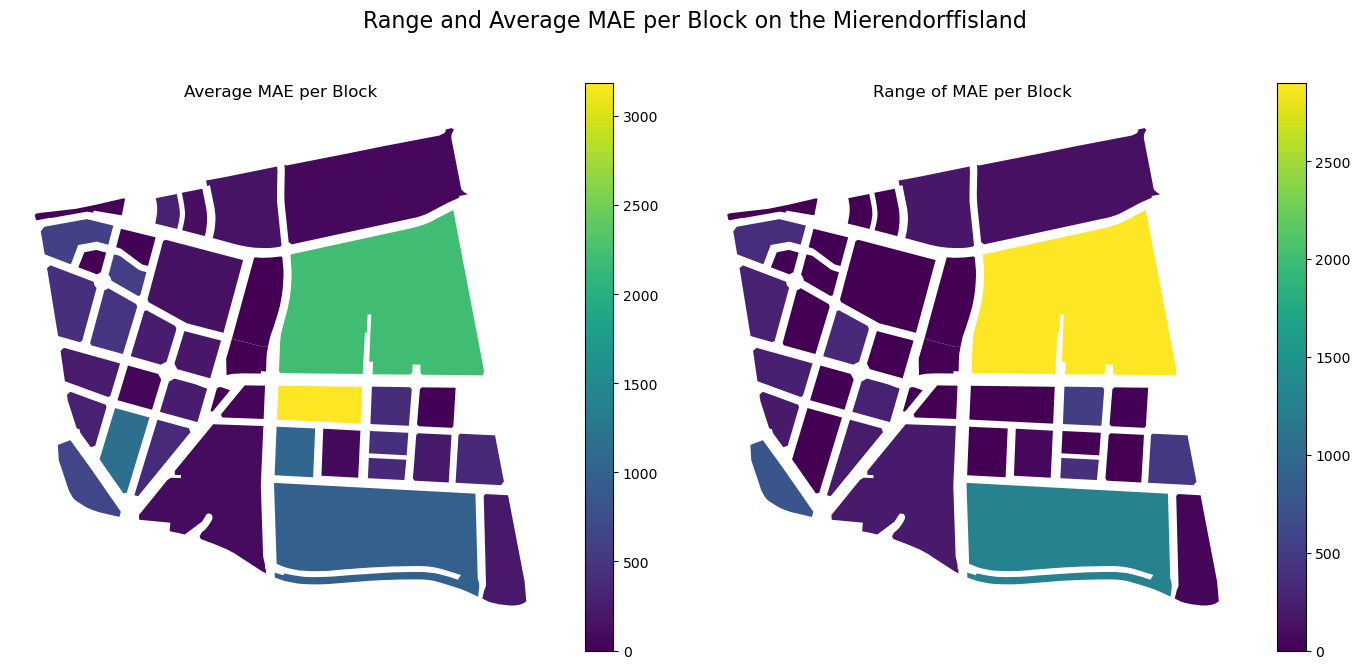

In [31]:
# Aggregate MAE values by block number to calculate range and average
agg_mae_df = mae_df.groupby('blknr')['mae'].agg(['mean', 'min', 'max']).reset_index()
agg_mae_df['range'] = agg_mae_df['max'] - agg_mae_df['min']
agg_mae_df.rename(columns={'mean': 'mae_mean'}, inplace=True)

# Merge with shape data
mae_gdf = block_data.merge(agg_mae_df, left_on='blknr', right_on='blknr', how='left')

# Plot the range and average MAE values
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Create the color map
cmap = plt.cm.viridis

# Define a normalization for the color mapping based on MAE mean
vmin_mean = mae_gdf['mae_mean'].min()
vmax_mean = mae_gdf['mae_mean'].max()
norm_mean = Normalize(vmin=vmin_mean, vmax=vmax_mean)

# Plotting average MAE
mae_gdf.plot(column='mae_mean', ax=axs[0], legend=True, cmap=cmap, norm=norm_mean)
axs[0].set_title('Average MAE per Block')
axs[0].axis('off')

# Define a normalization for the color mapping based on MAE range
vmin_range = mae_gdf['range'].min()
vmax_range = mae_gdf['range'].max()
norm_range = Normalize(vmin=vmin_range, vmax=vmax_range)

# Plotting range of MAE
mae_gdf.plot(column='range', ax=axs[1], legend=True, cmap=cmap, norm=norm_range)
axs[1].set_title('Range of MAE per Block')
axs[1].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust space between plots

# Add a common title
fig.suptitle('Range and Average MAE per Block on the Mierendorffisland', fontsize=16)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the common title

# Show plot
plt.show()

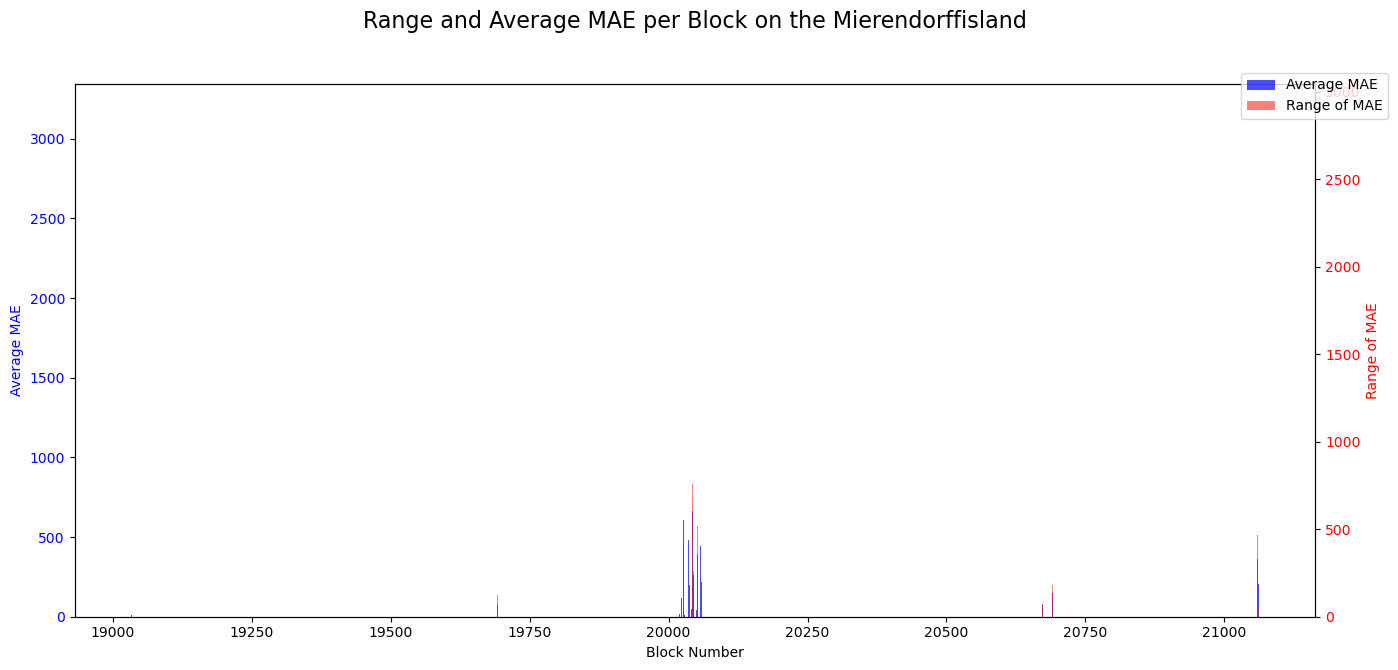

In [32]:
# Plot the range and average MAE values using a bar chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar chart for average MAE
ax1.bar(agg_mae_df['blknr'], agg_mae_df['mae_mean'], color='b', alpha=0.7, label='Average MAE')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Average MAE', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the range
ax2 = ax1.twinx()
ax2.bar(agg_mae_df['blknr'], agg_mae_df['range'], color='r', alpha=0.5, label='Range of MAE')
ax2.set_ylabel('Range of MAE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
fig.suptitle('Range and Average MAE per Block on the Mierendorffisland', fontsize=16)

# Show the legend
fig.legend(loc='upper right', bbox_to_anchor=(1,0.9))

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot
plt.show()
